# Goal: Find drivers of upsets in chess games and create a model to predict upsets 

* Upset is defined as a player with a lower rating winning a game agenst a player with a higher rating
* Model should make a predictions after having 'interviewed' each player as to thier intended opening and what defence they intend to use against a given opening 

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
import sklearn.preprocessing

import warnings
warnings.filterwarnings("ignore")

# Acquire

* Data acquired from Kaggle at https://www.kaggle.com/datasnaek/chess

In [2]:
df = pd.read_csv('games.csv')

In [3]:
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


# Prep for Explore

# notes

populatiry of opening
ave player rating of opening 


### Identify columns to investigate

In [4]:
# remove columns that are not useful

df = df[['rated', 'turns', 'victory_status',
         'winner', 'increment_code', 'white_rating',
         'black_rating', 'opening_eco', 'opening_name']]

df.head()

,rated,turns,victory_status,winner,increment_code,white_rating,black_rating,opening_eco,opening_name
0,False,13,outoftime,white,15+2,1500,1191,D10,Slav Defense: Exchange Variation
1,True,16,resign,black,5+10,1322,1261,B00,Nimzowitsch Defense: Kennedy Variation
2,True,61,mate,white,5+10,1496,1500,C20,King's Pawn Game: Leonardis Variation
3,True,61,mate,white,20+0,1439,1454,D02,Queen's Pawn Game: Zukertort Variation
4,True,95,mate,white,30+3,1523,1469,C41,Philidor Defense


In [5]:
df = df.rename(columns={'victory_status':'ended_as', 
                        'increment_code':'time_code', 
                        'opening_eco':'opening_code', 
                        'winner': 'winning_pieces'})

### Initial Thoughts

* As chess is a skill based game with no random elements (except first move) 
* Because of this the player with the highest level of skill will win any game not determined by variation in player performance in a given game will be won by the player with the highest level of skill 
* Therefor conditions underwhich variation in performance is the highest should result in the highest likelyhood of an upset
* It may be that more skilled players are able to maintain consistancy better than less skilled players under conditions that would increased variation in thier performance
* If this is true then increasing the level of veriation would decrease the likelyhood of an upset, meaning that some of the following hypotheses would have the opposite effect of what I am predicting

### Initial Hypothisese

* There will be few instances of upsets, possibly leading to an imbalanced data set
* As ratings for both players increase, the likelyhood of an upset will decrease 
* As the margin between player ratings increase the likelyhood of an upsets will decrease
* Shorter time incraments will increase the likelyhood of an upset
* Unranked games will have a higher likelyhood of an upset
* Games where the higher rated player is moving the white pieces (gaining first move advantage) will have a decreased likelyhood of of an upset
* Some opening/defense stratagies may be more or less prove to upsets
* openings/defences that are more popular or perfered by higher rated players may be more/less prone to upset

In [6]:
# check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   rated           20058 non-null  bool  
 1   turns           20058 non-null  int64 
 2   ended_as        20058 non-null  object
 3   winning_pieces  20058 non-null  object
 4   time_code       20058 non-null  object
 5   white_rating    20058 non-null  int64 
 6   black_rating    20058 non-null  int64 
 7   opening_code    20058 non-null  object
 8   opening_name    20058 non-null  object
dtypes: bool(1), int64(3), object(5)
memory usage: 1.2+ MB


### create an upset column

In [7]:
# remove white space from values in object variables
columns = ['ended_as', 'winning_pieces', 
         'time_code', 'opening_name', 'opening_name']

for column in columns:
    
    df[column] = df[column].apply(lambda value: value.strip())

In [8]:
# add column for if lowest rated player wins the game

df['upset'] = (((df.white_rating > df.black_rating) & (df.winning_pieces == 'black')) |
               ((df.white_rating < df.black_rating) & (df.winning_pieces == 'white')))

In [9]:
df.head()

,rated,turns,ended_as,winning_pieces,time_code,white_rating,black_rating,opening_code,opening_name,upset
0,False,13,outoftime,white,15+2,1500,1191,D10,Slav Defense: Exchange Variation,False
1,True,16,resign,black,5+10,1322,1261,B00,Nimzowitsch Defense: Kennedy Variation,True
2,True,61,mate,white,5+10,1496,1500,C20,King's Pawn Game: Leonardis Variation,True
3,True,61,mate,white,20+0,1439,1454,D02,Queen's Pawn Game: Zukertort Variation,True
4,True,95,mate,white,30+3,1523,1469,C41,Philidor Defense,False


### Examine Object Variables

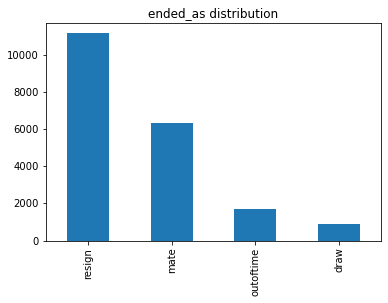

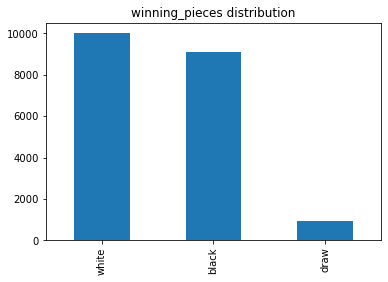

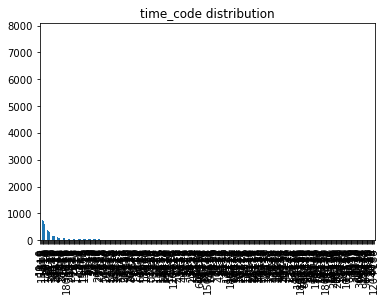

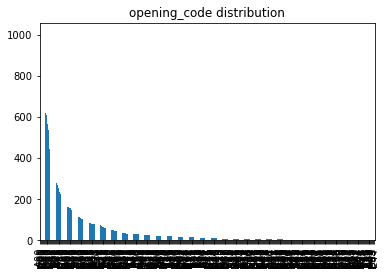

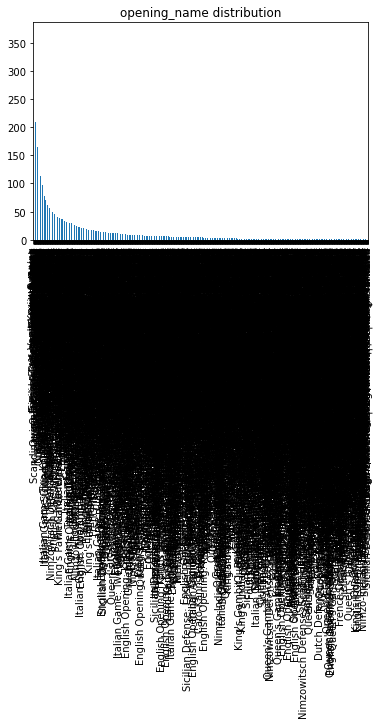

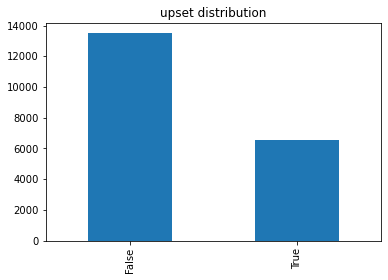

In [10]:
# distribution of the data
columns = ['ended_as', 'winning_pieces', 
           'time_code', 'opening_code', 
           'opening_name', 'upset']

for col in columns:
    
    df[col].value_counts().plot(kind='bar', title = f"{col} distribution")
    
    plt.show()

### Takeaways

* Resignations usually happen when mate is enevitable I see no reason to seperate the two
* I wonder if running out of time has an effect on upsets? 
* White does have an advantage, though it is much smaller than I thought it would be, at about 10% higher number of wins than black
* time_code, opening_code, and opening_name, have too many values to sort through at the moment and will have to be binned or pruened
* upsets represent about 1/3 or the data, which is higher than I thought it would be

### Examine Quantitative Variables

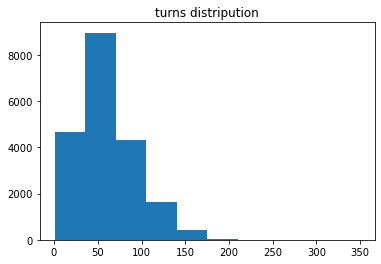

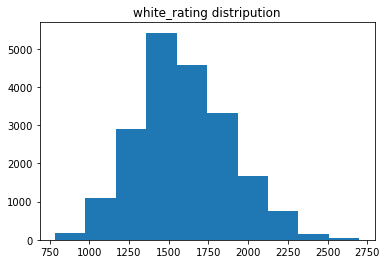

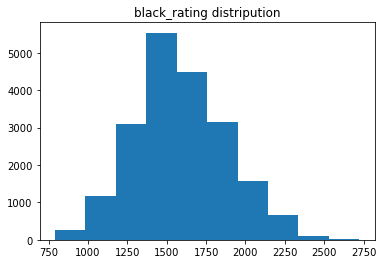

In [11]:
# distribution of the data
cols = ['turns', 'white_rating', 'black_rating']

for col in cols:
    plt.hist(df[col])
    plt.title(col+' distripution')
    plt.show()

### Takeaways

* Turns is slightly right skewed 
* Black and white rating distributions are pretty normally distributed and are nearly if not entierly identical

In [12]:
df.time_code.value_counts()

10+0       7721
15+0       1311
15+15       850
5+5         738
5+8         697
           ... 
120+1         1
1+45          1
30+7          1
60+4          1
120+180       1
Name: time_code, Length: 400, dtype: int64

### I'm goint to try to prune the object columns by removing the values that do not have a significant represintation I an setting my trial cut off point at 50 or more occurrences 

In [13]:
columns = ['ended_as', 'winning_pieces', 
           'time_code', 'opening_code', 
           'opening_name', 'upset']

for col in columns:
    
    print(col.upper())
    print(df[col].value_counts())
    print()

ENDED_AS
resign       11147
mate          6325
outoftime     1680
draw           906
Name: ended_as, dtype: int64

WINNING_PIECES
white    10001
black     9107
draw       950
Name: winning_pieces, dtype: int64

TIME_CODE
10+0       7721
15+0       1311
15+15       850
5+5         738
5+8         697
           ... 
120+1         1
1+45          1
30+7          1
60+4          1
120+180       1
Name: time_code, Length: 400, dtype: int64

OPENING_CODE
A00    1007
C00     844
D00     739
B01     716
C41     691
       ... 
A59       1
A89       1
E03       1
D59       1
E44       1
Name: opening_code, Length: 365, dtype: int64

OPENING_NAME
Van't Kruijs Opening                                                      368
Sicilian Defense                                                          358
Sicilian Defense: Bowdler Attack                                          296
Scotch Game                                                               271
French Defense: Knight Variation          

In [14]:
df.isnull().sum()

rated             0
turns             0
ended_as          0
winning_pieces    0
time_code         0
white_rating      0
black_rating      0
opening_code      0
opening_name      0
upset             0
dtype: int64

In [22]:
columns = ['ended_as', 'winning_pieces', 
           'time_code', 'opening_code', 
           'opening_name', 'upset']

for column in columns:
    
    value_set = set([value for value in set(df[column].to_list()) if df[column].value_counts()[value] > 50])
    
    print(column.upper())
    print(value_set)
    print('Length:', len(value_set))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print()
    
    df[column] = df[column].apply(lambda value : value if value in value_set else np.nan)
    
df = df.dropna()
    
    
print("VALUE COUNTS")
for column in columns:
    
    print("VALUE COUNTS")
    print(column.upper())
    print(df[column].value_counts())
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print()

ENDED_AS
{'mate', 'outoftime', 'resign', 'draw'}
Length: 4
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

WINNING_PIECES
{'black', 'white', 'draw'}
Length: 3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

TIME_CODE
{'10+3', '8+0', '10+5', '10+10', '15+10', '30+0', '25+0', '10+0', '5+10', '5+8', '15+5', '5+5', '7+2', '10+2', '15+0', '20+0', '15+15'}
Length: 17
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

OPENING_CODE
{'A40', 'C41', 'B54', 'B00', 'B13', 'C62', 'C42', 'C46', 'B21', 'B07', 'C24', 'B22', 'C44', 'B12', 'A20', 'B30', 'B40', 'A45', 'C45', 'C55', 'C50', 'C20', 'D06', 'D20', 'B10', 'B06', 'B50', 'A00', 'D01', 'C01', 'C40', 'C23', 'B23', 'A03', 'D30', 'B01', 'D00', 'C65', 'C00', 'A02', 'B20', 'D02'}
Length: 42
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

OPENING_NAME
{'Sicilian Defense: Closed Variation', "King's Knight Opening", 'French Defense: Exchange Variation', 'Sicilian Defense: Nyezhmetdinov-Rossolimo Attack', 'Philidor Defense', 'Pirc Defense #4', 'It

In [16]:
df.shape

(8196, 10)

In [17]:
df.to_csv('games_preped.csv')

In [18]:
df = pd.read_csv('games_preped.csv')

In [19]:
df

,Unnamed: 0,rated,turns,ended_as,winning_pieces,time_code,white_rating,black_rating,opening_code,opening_name,upset
0,2,True,61,mate,white,5+10,1496,1500,C20,King's Pawn Game: Leonardis Variation,True
1,3,True,61,mate,white,20+0,1439,1454,D02,Queen's Pawn Game: Zukertort Variation,True
2,9,True,119,mate,white,10+0,1381,1209,B01,Scandinavian Defense: Mieses-Kotroc Variation,False
3,13,False,31,resign,black,8+0,1381,1607,C00,French Defense #2,False
4,14,False,31,mate,white,15+15,1094,1141,C50,Four Knights Game: Italian Variation,True
...,...,...,...,...,...,...,...,...,...,...,...
8191,20050,True,9,outoftime,white,10+0,1243,1142,A20,English Opening: King's English Variation,False
8192,20051,True,58,mate,black,10+10,1237,1231,C00,French Defense: Knight Variation,True
8193,20054,True,82,mate,black,10+0,1233,1196,A41,Queen's Pawn,True
8194,20055,True,35,mate,white,10+0,1219,1286,D00,Queen's Pawn Game: Mason Attack,True
